身長 167cm という数字は、頭のてっぺんが 0cm から数えてプラスの方向に 167 cm のメモリと重なったことを意味しています。
しかし、分析する際は 0cm を基準にするよりも、平均的な身長 170 cm を基準として、平均より 3cm 低いと解釈するのが普通です。
このように基準をずらす操作を **中心化** といいます。

*中心化の目的は、解釈性向上の他に、モデルの学習効率化や線形性の条件を満たすことなどがあります。


In [1]:
import numpy as np


# 二十代前半男女の長座体前屈 (stretch) と 50m走 (sprint) の標本データ
np.random.seed(2)
boys_stretch = np.random.normal(45.76, 10.01, 100)
girls_stretch = np.random.normal(45.92, 9.94, 86)
boys_sprint = np.random.normal(7.27, 0.52, 100)
girls_sprint = np.random.normal(9.09, 0.79, 86)


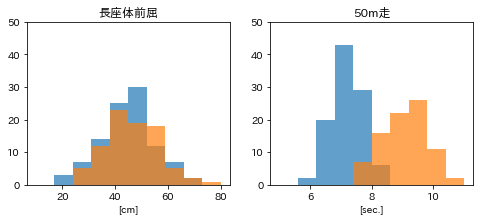

In [14]:
import matplotlib.pyplot as plt
import japanize_matplotlib

_ = None


def plot(b_st, g_st, b_sp, g_sp, range_st=None, range_sp=None):
    fig, axes = plt.subplots(1, 2, figsize=[8, 3])
    axes[0].hist(b_st, alpha=0.7, range=range_st)
    axes[0].hist(g_st, alpha=0.7, range=range_st)
    axes[0].set(xlabel="[cm]", title="長座体前屈", ylim=[0, 50])
    axes[1].hist(b_sp, alpha=0.7, range=range_sp)
    axes[1].hist(g_sp, alpha=0.7, range=range_sp)
    axes[1].set(xlabel="[sec.]", title="50m走", ylim=[0, 50])


plot(
    boys_stretch,
    girls_stretch,
    boys_sprint,
    girls_sprint,
    range_st=[10, 80],
    range_sp=[5, 11],
)


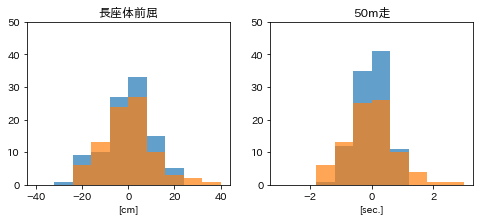

In [11]:
def centerize(data):
    return data - np.mean(data)


plot(
    *map(centerize, [boys_stretch, girls_stretch, boys_sprint, girls_sprint]),
    range_st=[-40, 40],
    range_sp=[-3, 3],
)


もともと平均に差があったはずの男女の分布が混じってしまいました。

ここで、平均を毎回変えずに男子の

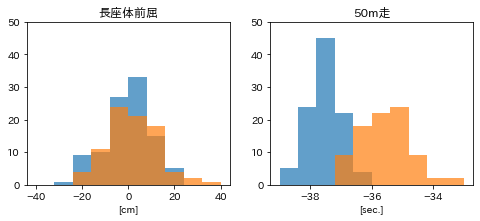

In [32]:
mean = np.mean(boys_stretch)


def centerize(data):
    return data - mean


boys_stretch_1 = centerize(boys_stretch)
girls_stretch_1 = centerize(girls_stretch)

boys_sprint_1 = centerize(boys_sprint)
girls_sprint_1 = centerize(girls_sprint)

plot(boys_stretch_1, girls_stretch_1, boys_sprint_1, girls_sprint_1, range_st=[-40, 40], range_sp=[-39, -33])


当たり前ですが、長座体前屈の平均を基準としているので 50m 走の結果が中心家できていませんね。


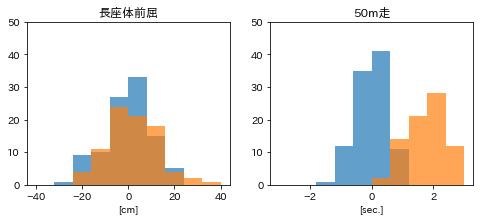

In [21]:
def centerize(data, mean=None):
    if mean is None:
        mean = np.mean(data)
        return data - mean, mean
    else:
        return data - mean, mean


boys_stretch_1, boys_stretch_mean = centerize(boys_stretch)
girls_stretch_1, _ = centerize(girls_stretch, boys_stretch_mean)

boys_sprint_1, boys_sprint_mean = centerize(boys_sprint)
girls_sprint_1, _ = centerize(girls_sprint, boys_sprint_mean)

plot(
    boys_stretch_1,
    girls_stretch_1,
    boys_sprint_1,
    girls_sprint_1,
    range_st=[-40, 40],
    range_sp=[-3, 3],
)


左右の分布をどちらも男子の平均が中心となるようにスライドすることができました。

ただ、（細かいく感じるかもしれまえんが、）この実装には 2 つの気になる点があります。

- あるデータを入力として受け取り、中心化をしたデータを出力する処理なのに、データでない変数を受け取っている。
  - 理想形は `Y = centerize(X)` だが、`Y = centerize(X, ?)` となっている。
- 2 つの標本を中心化する途中に、`_mean` で終わる 2 つの変数が関数の外（グローバルスコープ）に漏れている。
  - 関数の内部の処理が、関数の外部の情報に依存している。

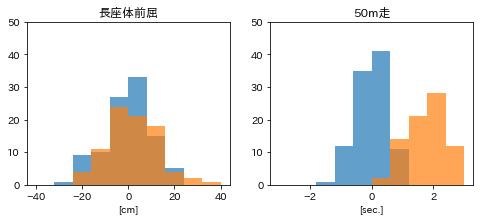

In [26]:
class Centerizer:
    def __init__(self, name):
        self.name = name
        self.mean = None

    def fit(self, data):
        self.mean = np.mean(data)

    def transform(self, data):
        return data - self.mean


stretch = Centerizer("stretch")
stretch.fit(boys_stretch)
boys_stretch_2 = stretch.transform(boys_stretch)
girls_stretch_2 = stretch.transform(girls_stretch)

sprint = Centerizer("sprint")
sprint.fit(boys_sprint)
boys_sprint_2 = sprint.transform(boys_sprint)
girls_sprint_2 = sprint.transform(girls_sprint)

plot(
    boys_stretch_2,
    girls_stretch_2,
    boys_sprint_2,
    girls_sprint_2,
    range_st=[-40, 40],
    range_sp=[-3, 3],
)


まず、事前に `self.mean` を計算しておいて、それを内部に保持しておきます。
そして、中心化するときはデータ `data` だけを受け取り、保持しておいた `self.mean` を用いて変換します。

TODO: メソッドやアトリビュートの名前を説明する。

関数とクラスのどちらの実装の方が良いか、好みはわかれるかもしれませんが、
機械学習のライブラリは

In [ ]:
from torch import nn


class PTModel(nn.Module):
    def __init__(self):
        super().__init__()
        # ハイパーパラメータを定義する
        self.config = ...
        # パラメータを初期化する
        self.layer = ...
        nn.Linear

    def forward(self, X):
        # モデル構造を定義する
        # すなわち、入力 X を出力 Y に変換する処理を実装する
        Y = self.layer(X)
        return Y

    def backward(self, X):
        # パラメータを更新する処理（=学習）を実装する
        # nn.Module 内に定義済みなので自分で実装する必要はない
        ...


class SKModel:
    def __init__(self):
        # ハイパーパラメータを定義する
        self.config = ...

    def fit(self, X):
        # 学習して、得られたパラメータを属性に追加する。
        self.param_ = solve(X)
        return self

    def predict(self, X):
        # 予測する
        return model(X, self.param_)


難しいのが独自に何かを作るときです。

とりあえず関数ベースで実装して、
関数の処理がスコープ外の変数 $a$ に依存しているなと感じたら、
self.a を内部にもったクラスに実装しなおすのが良いと思います。
